## Imports and Setup

In [32]:
import os 
os.chdir('../')
from utils import plot_utils
from utils import post_utils
from utils import config_utils

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Config Files

In [33]:
iso_code = "SEN"
data_config_file = os.path.join(os.getcwd(), "configs/data_configs/data_config_ISO_AF.yaml")
data_config = config_utils.load_config(data_config_file)

## Load Data

In [34]:
master = post_utils.read_file(iso_code, data_config, source="master")
osm = post_utils.read_file(iso_code, data_config, source="osm_overture")

In [44]:
master = post_utils.read_file(iso_code, data_config, source="master")
osm = post_utils.read_file(iso_code, data_config, source="osm_overture")
preds = post_utils.read_file(iso_code, data_config, source="preds")
print(preds.shape)
preds.head(2)

Best cam method: gradcam
(15967, 9)


,prob,UID,sum,group,ADM1,ADM2,ADM3,PUID,geometry
0,0.966634,23507,22.0,7367,Diourbel,Diourbel,Ndindy,Diourbel_23507,POINT (-1814593.415 1665931.749)
1,0.966054,178498,15.0,12109,Ziguinchor,Bignona,Sindian,Bignona_178498,POINT (-1811869.892 1464003.347)


## Analyse Government vs AI Prediction Results

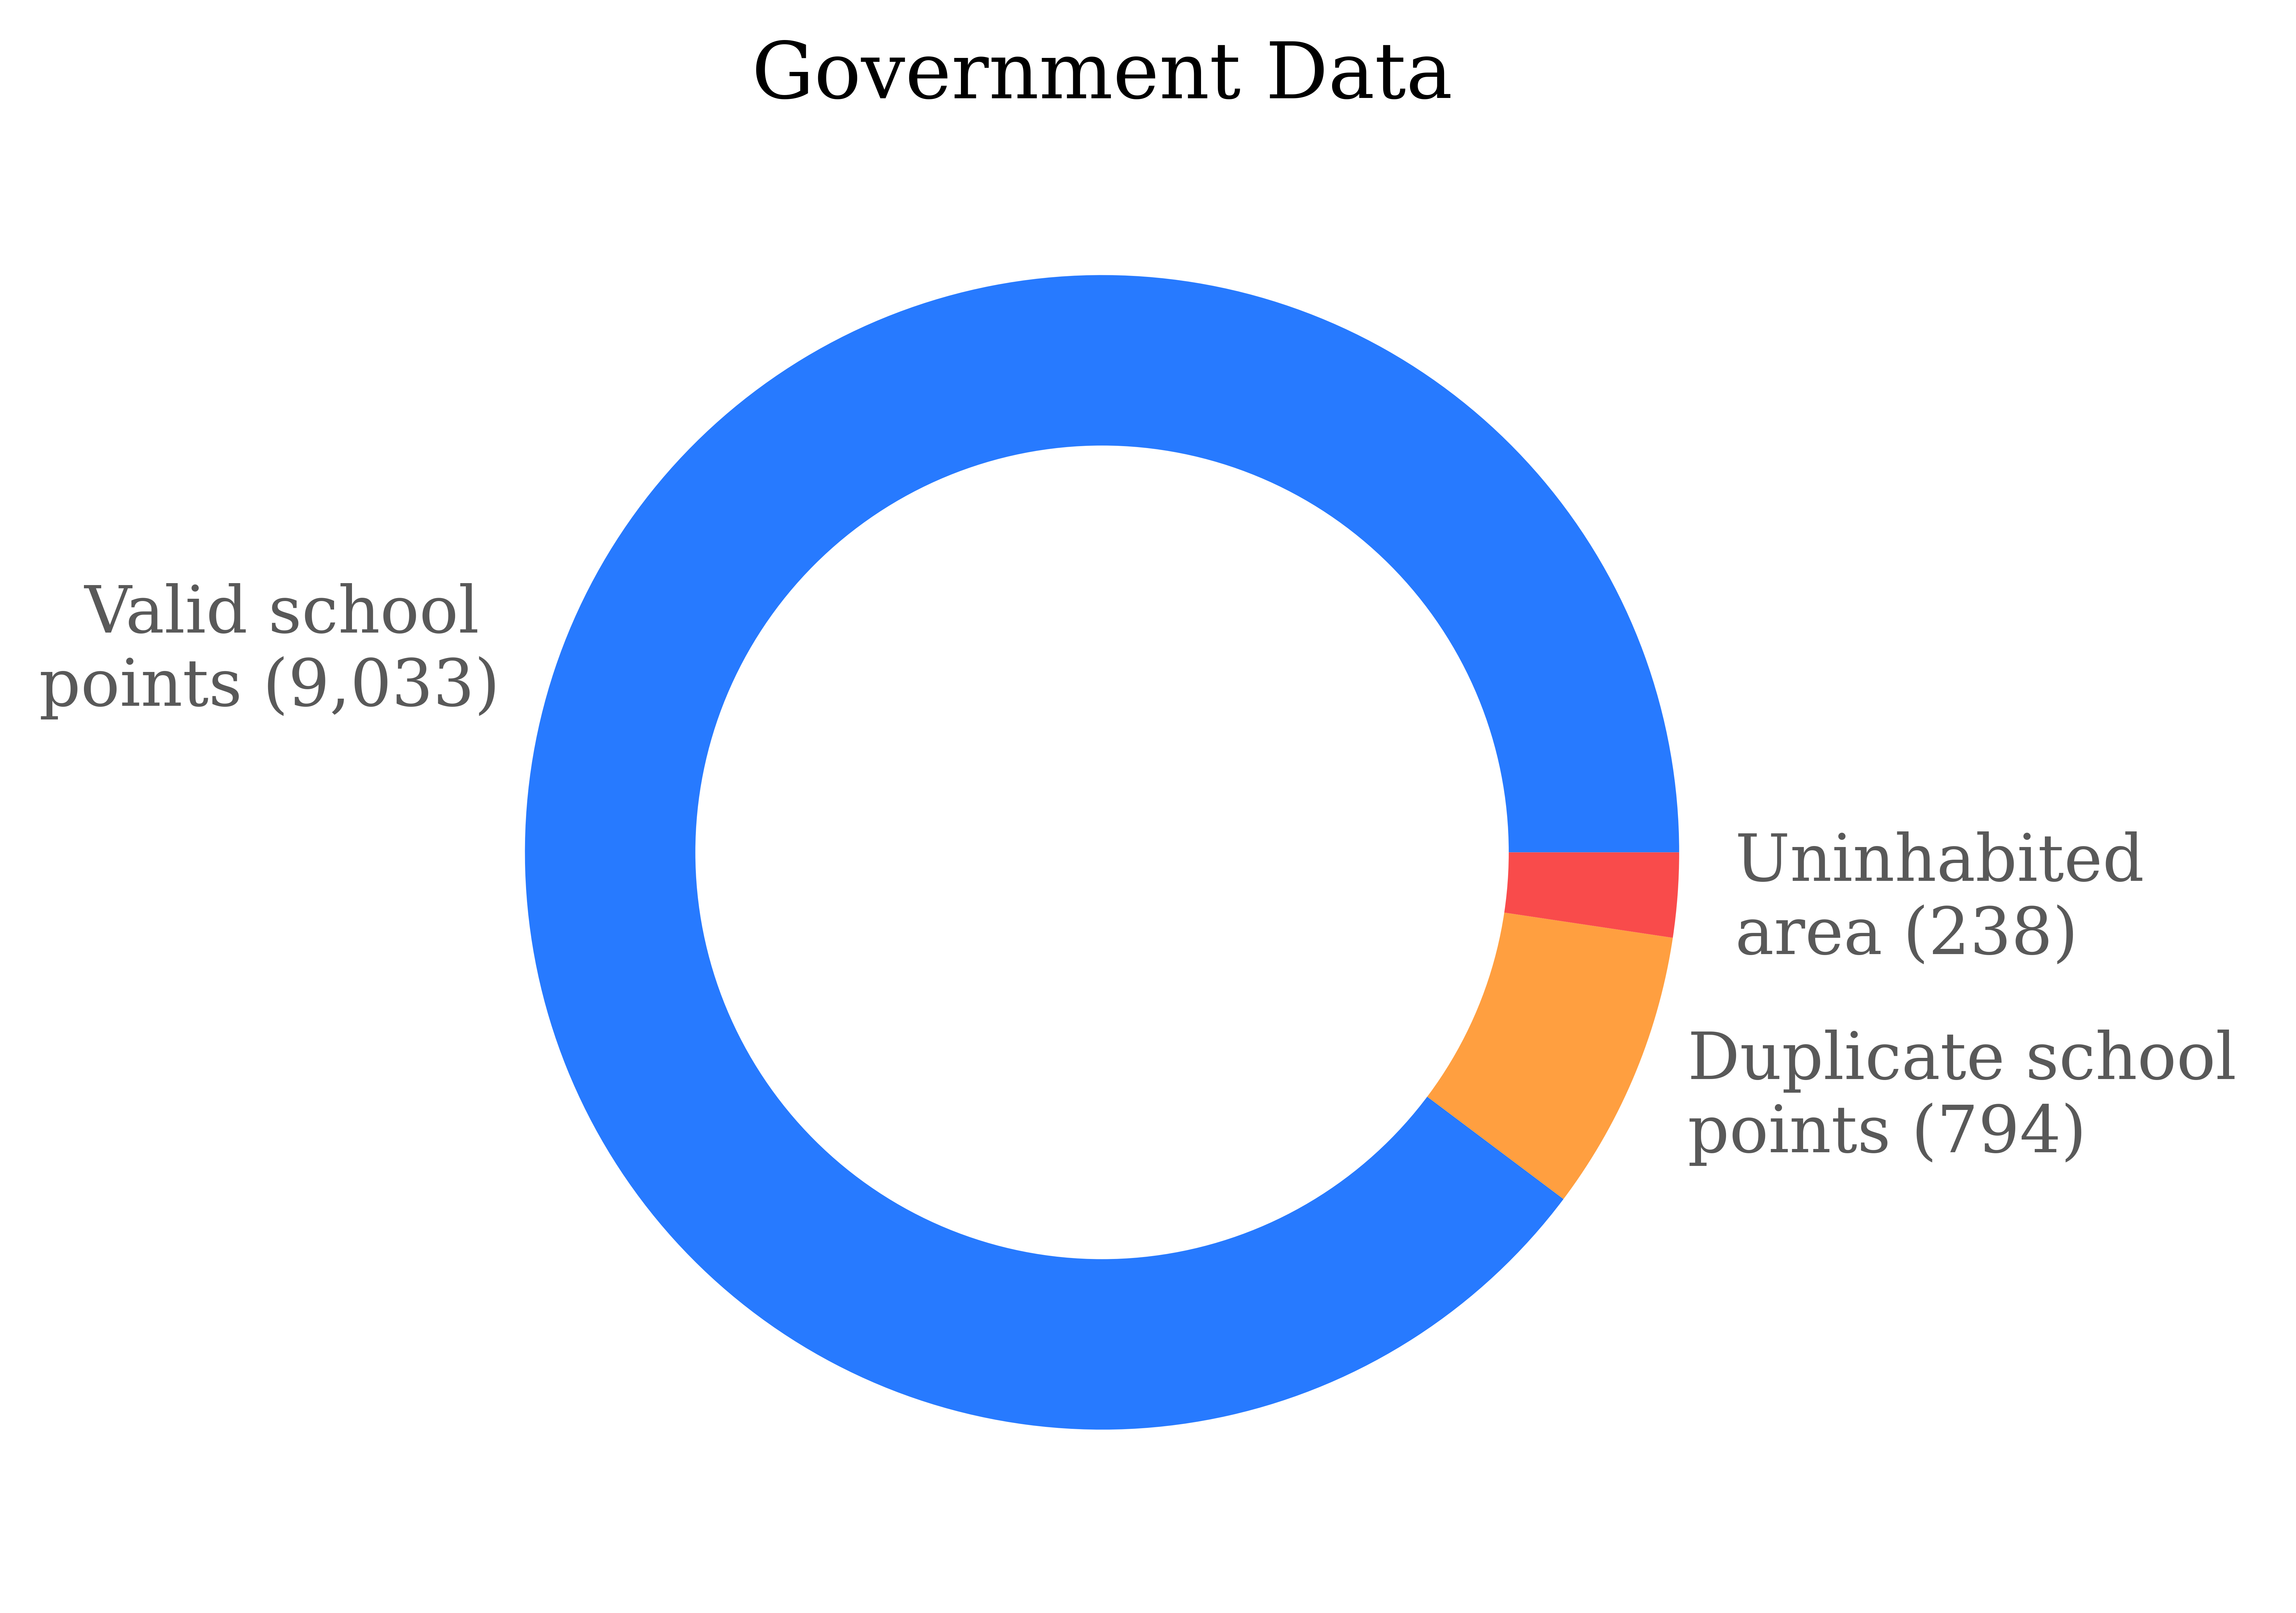

In [45]:
plot_utils.plot_pie_chart(master, source="master")

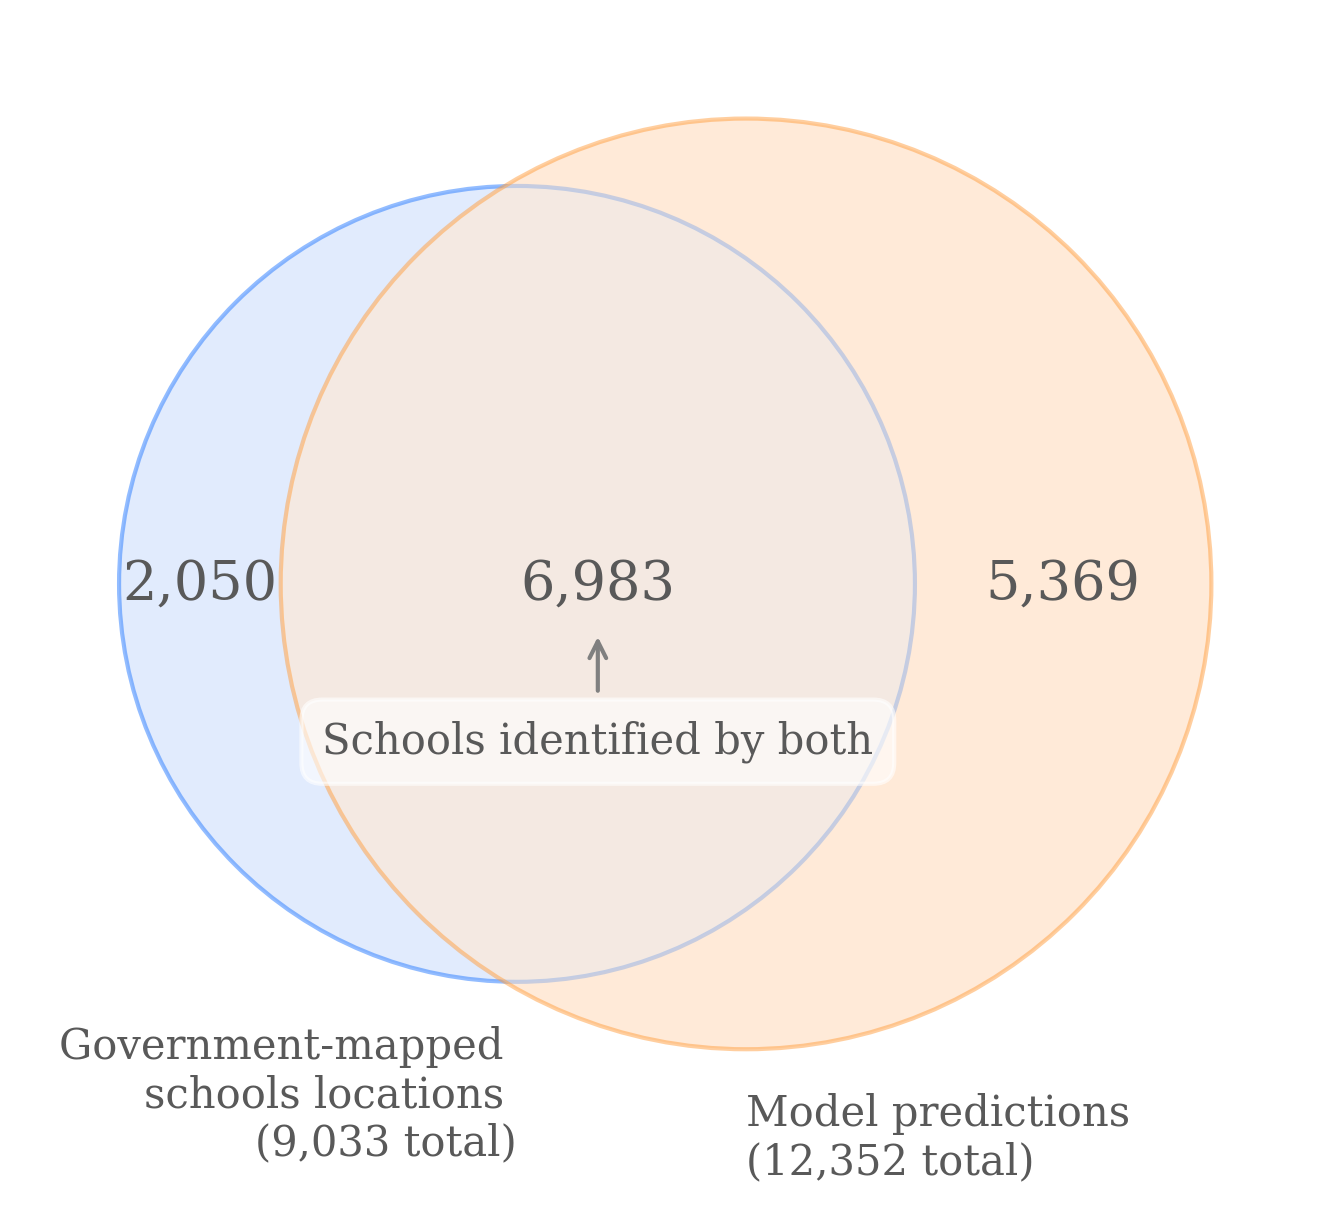

In [49]:
plot_utils.plot_venn_diagram(master, preds[preds.prob >= 0.5], threshold_dist=250)

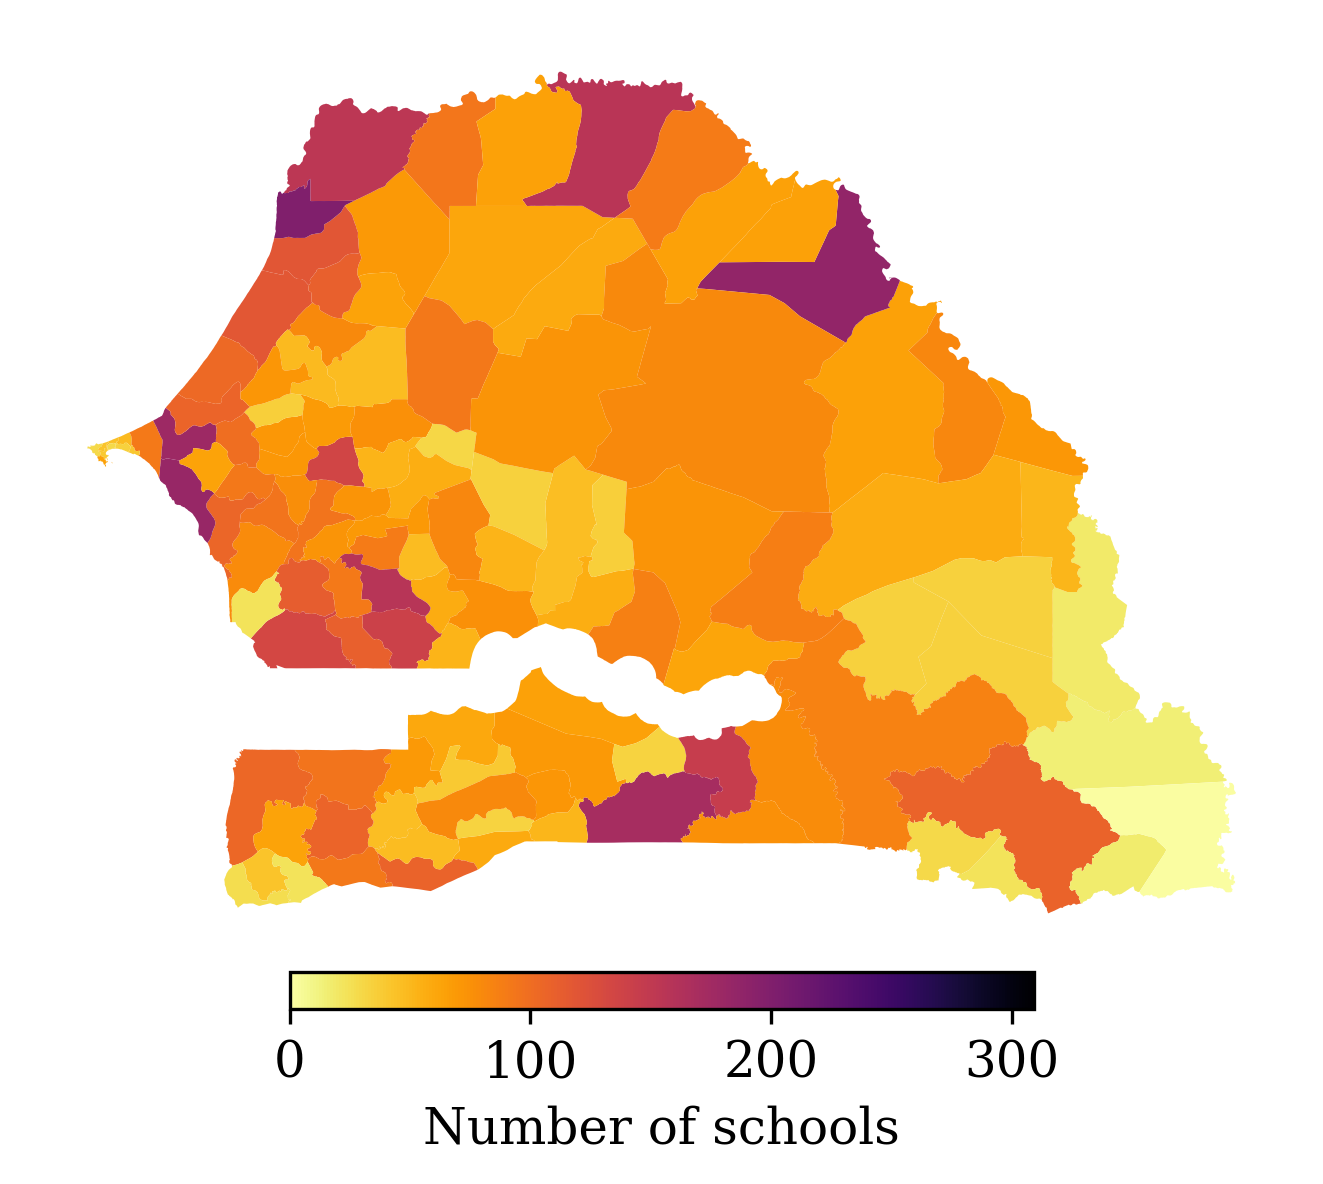

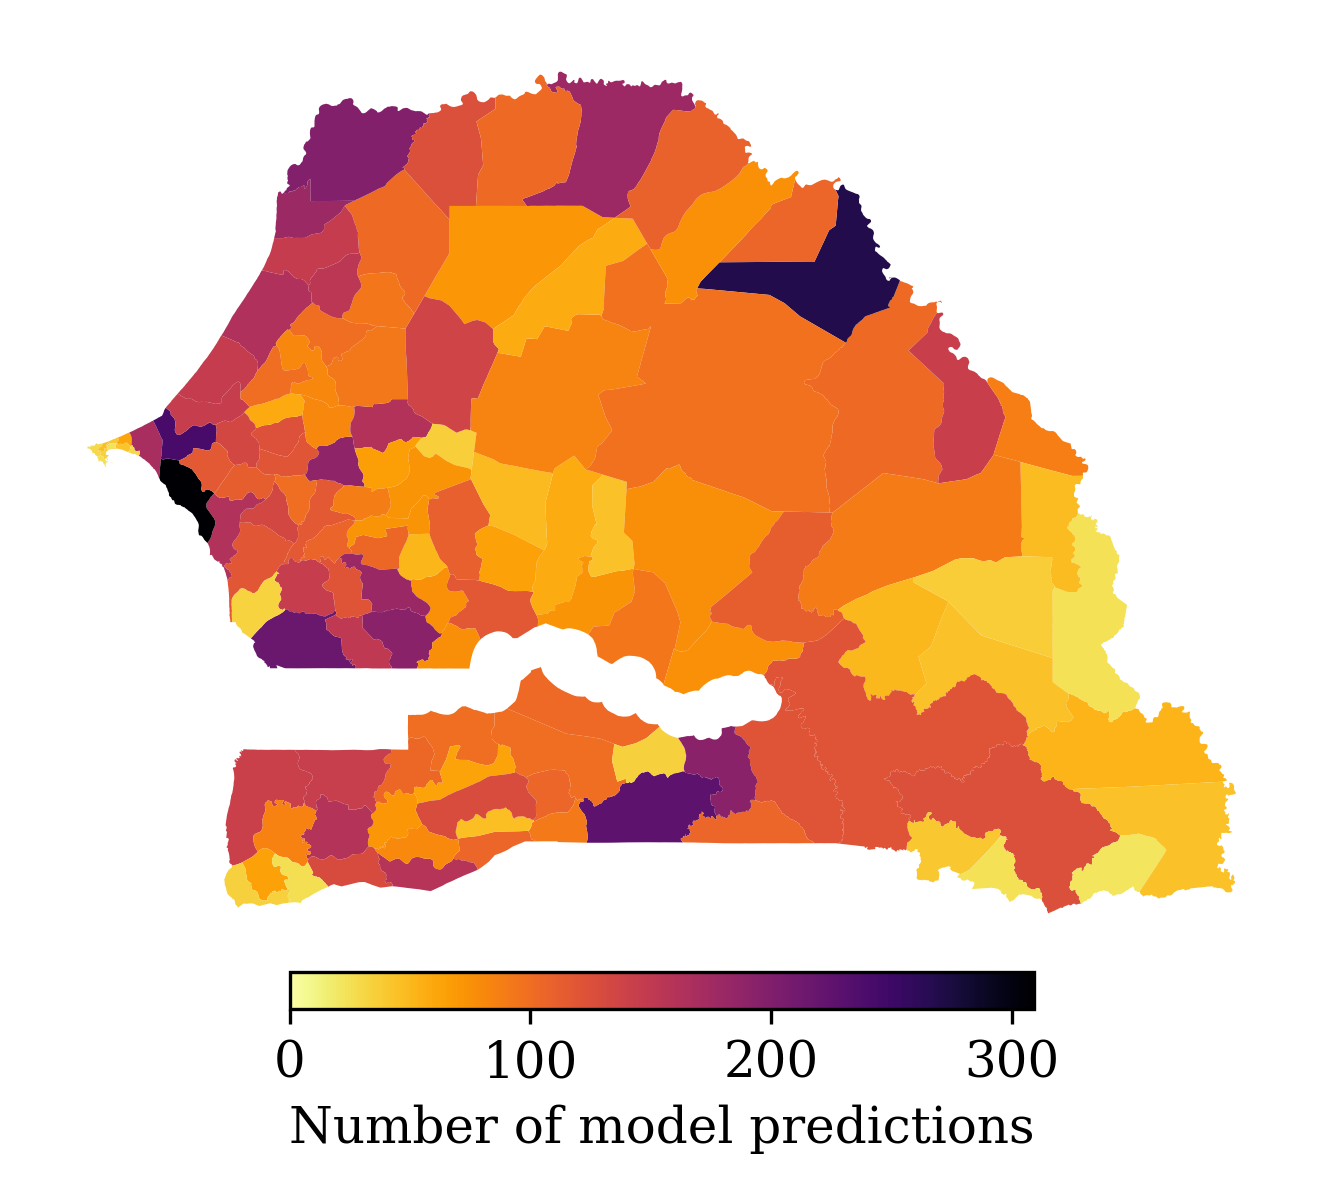

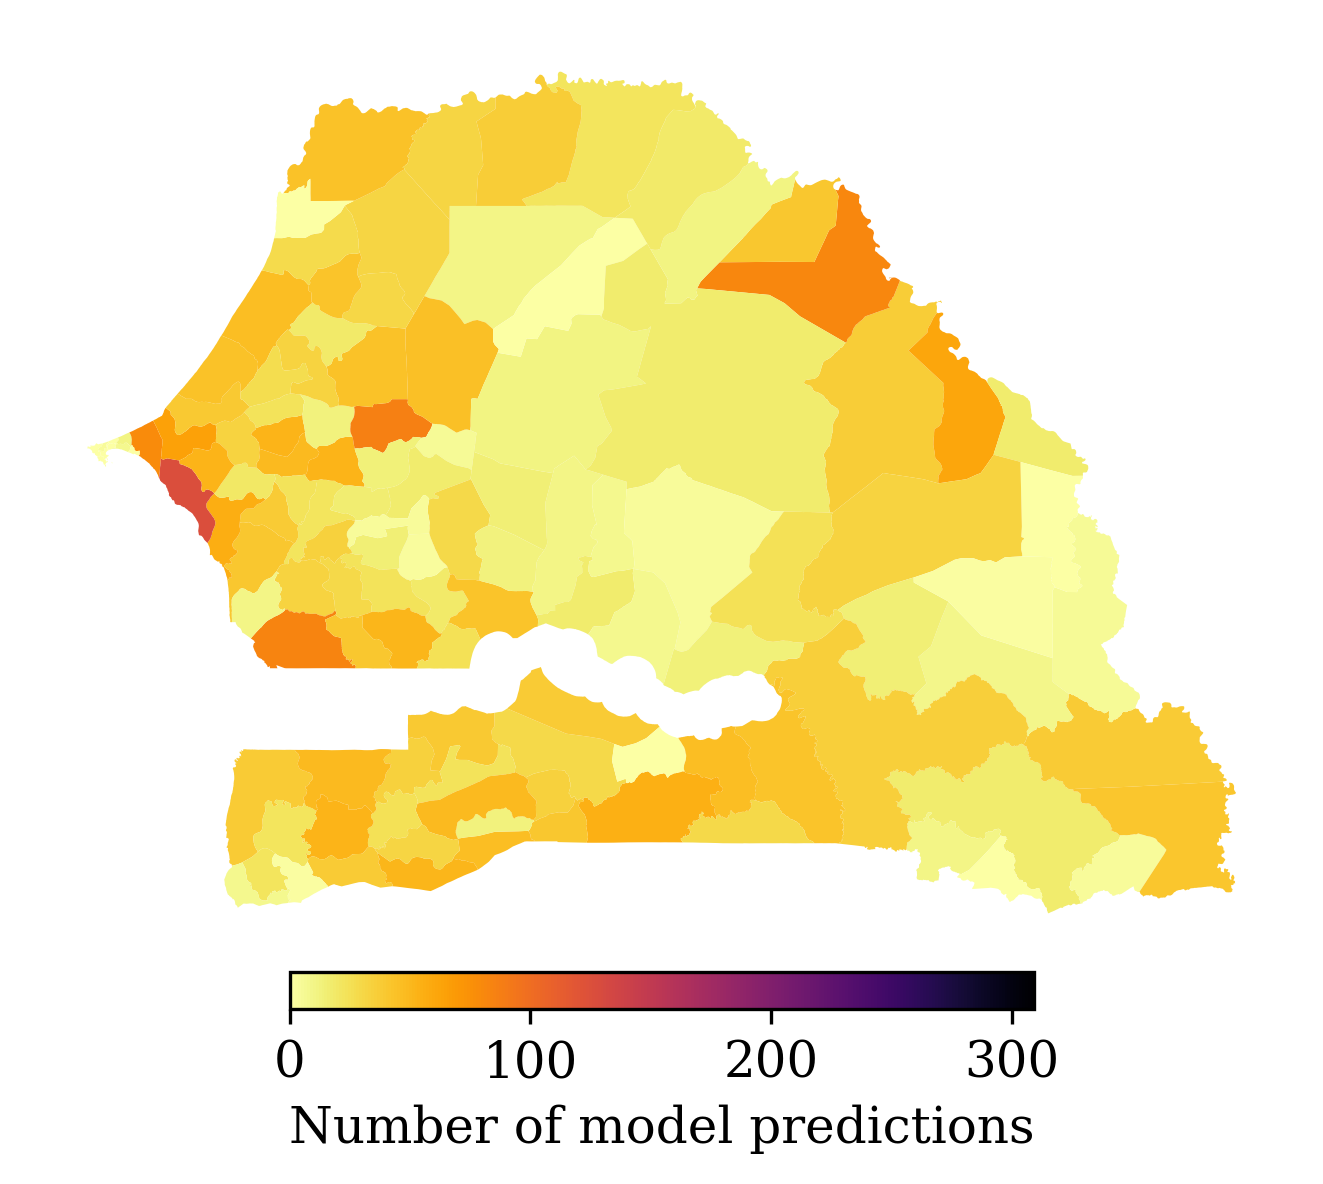

In [52]:
plot_utils.plot_choropleth(master, preds[preds.prob > 0.5], data_config, iso_code, threshold_dist=250, adm_level="ADM3")

## Plot Charts for Post-prediction Analysis

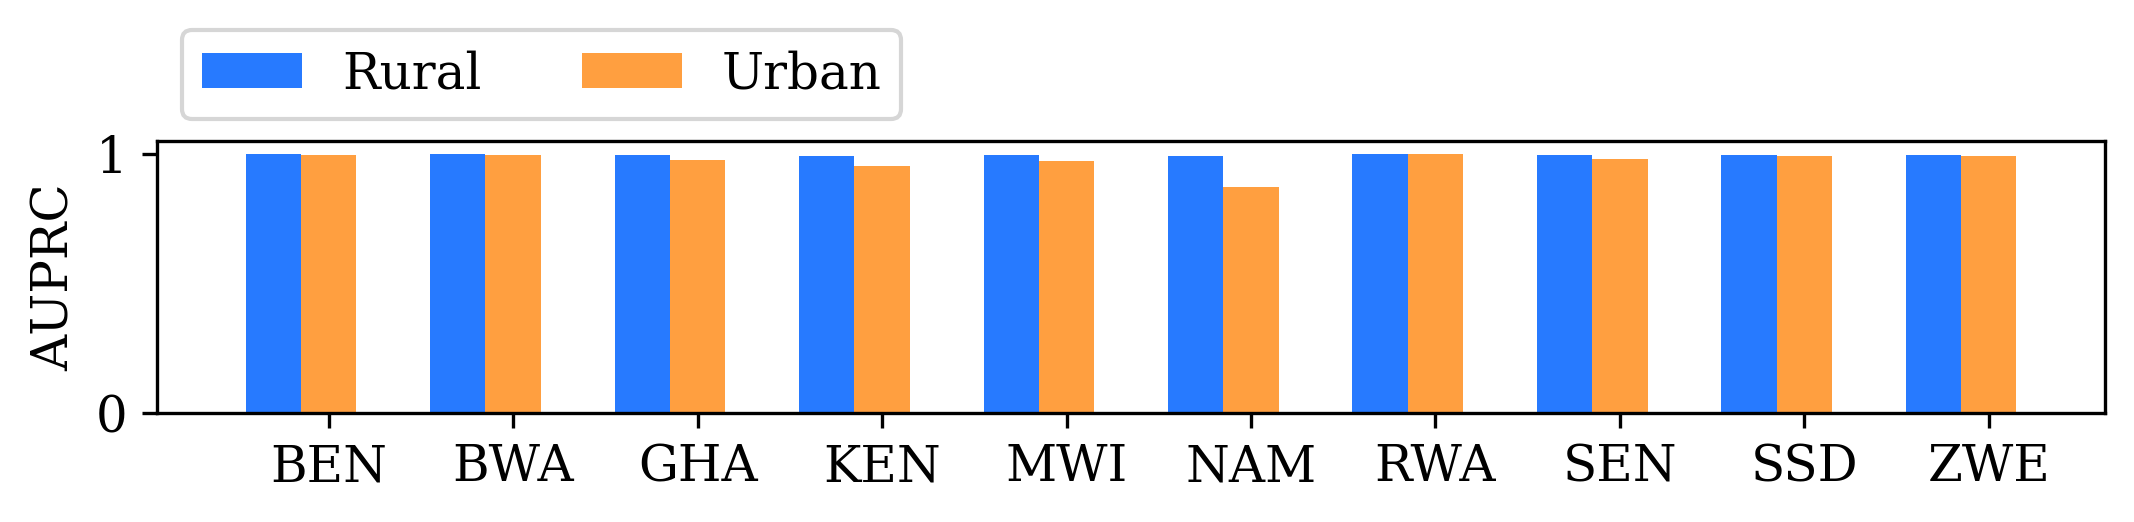

In [15]:
plot_utils.plot_rurban(data_config)

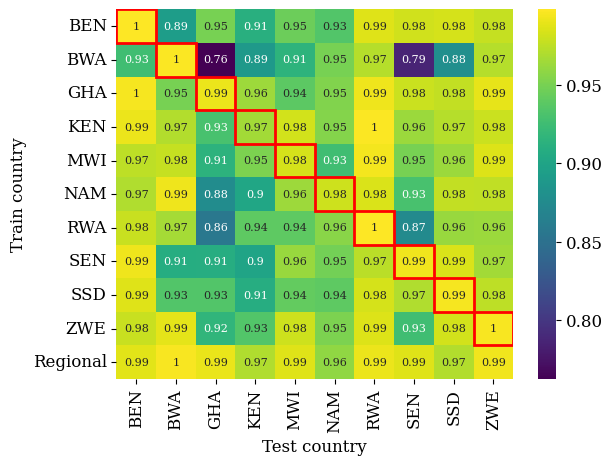

In [11]:
exp_dir = os.path.join(os.getcwd(), "cv")
plot_utils.plot_heatmap(data_config, exp_dir)

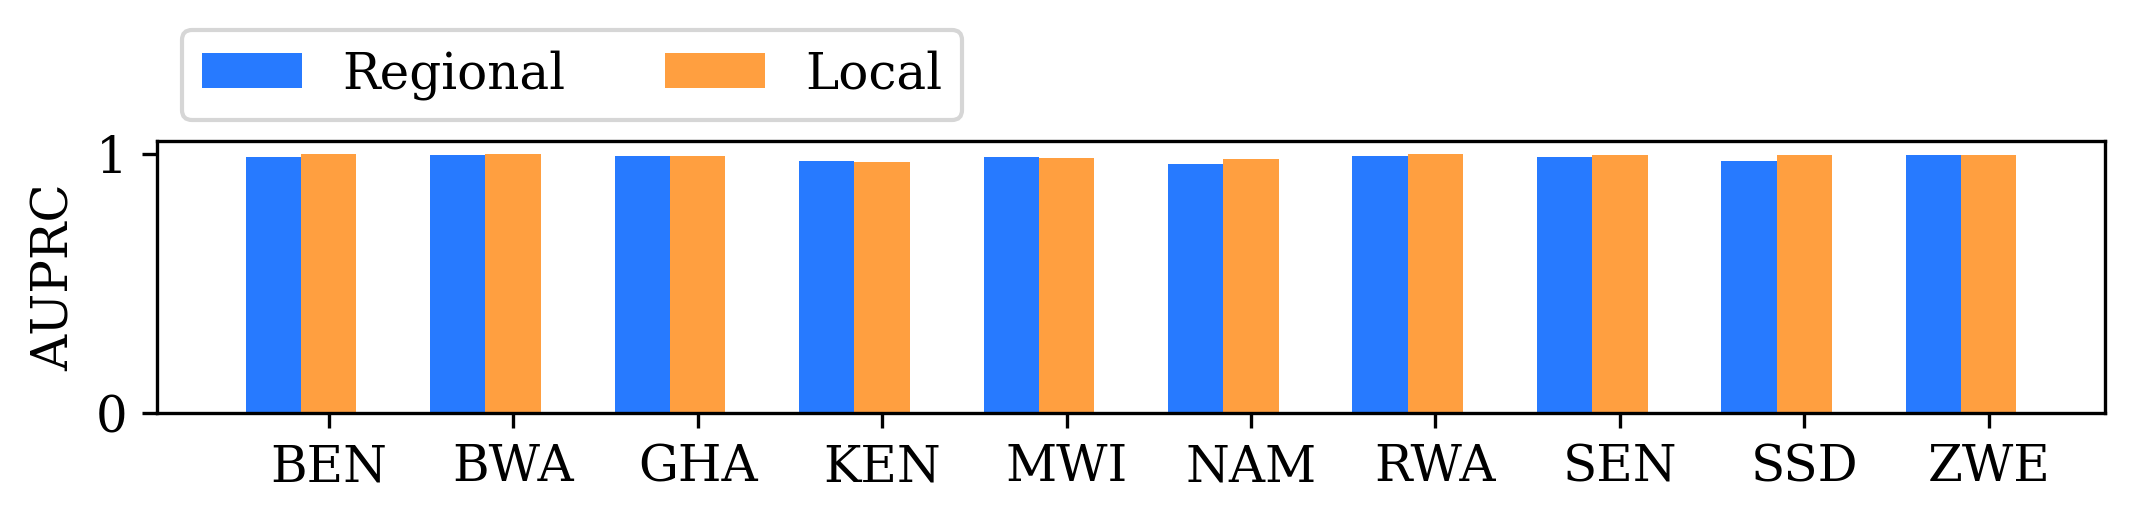

In [13]:
plot_utils.plot_regional_vs_country(data_config, regional_code="AF");